## System Models

In [30]:
import autograd.numpy as np
from autograd import jacobian, grad
from scipy.linalg import logm
import matplotlib.pyplot as plt

class VanDerPol(object):
    """
    2D dynamics describing the van der pol osciallator
    """
    def __init__(self, eps:float=1.0, dt:float=0.01):
        self.name = "VanDerPol"
        self.eps = eps 
        self.dt = dt
        self.dfdx = jacobian(self.dynamics, argnum=0)
        self.num_states = 2
        self.reset()

    def reset(self):
        self.state = np.random.uniform(-3., 3., size=(self.num_states,))
        return self.state.copy()

    def dynamics(self, x):
        xdot = np.array([
            x[1],
            -x[0] + self.eps * (1 - x[0]**2) * x[1]
        ])
        return xdot

    def step(self):
        k1 = self.dt * self.dynamics(self.state)
        k2 = self.dt * self.dynamics(self.state + k1/2.)
        k3 = self.dt * self.dynamics(self.state + k2/2.)
        k4 = self.dt * self.dynamics(self.state + k3)

        self.state = self.state + (1/6.) * (k1+2.0*k2+2.0*k3+k4)
        return self.state.copy()

class ContinuousLinearSystem(object):
    """
    2D diagonal, stable linear dynamics (easy easy easy)
    """
    def __init__(self, dt:float=0.01):
        self.name = "LinearSystem"
        self.dt = dt
        self.dfdx = jacobian(self.dynamics, argnum=0)
        self.num_states = 2
        self.reset()
        self.evals = [np.exp(-1*dt), np.exp(-2*dt)]  # eigenvalues of the discretized system

    def reset(self):
        self.state = np.random.uniform(-15., 15., size=(self.num_states,))
        return self.state.copy()

    def dynamics(self, x):
        xdot = np.array([
            -x[0] + x[1],
            -2*x[1]
        ])
        return xdot

    def step(self):
        k1 = self.dt * self.dynamics(self.state)
        k2 = self.dt * self.dynamics(self.state + k1/2.)
        k3 = self.dt * self.dynamics(self.state + k2/2.)
        k4 = self.dt * self.dynamics(self.state + k3)

        self.state = self.state + (1/6.) * (k1+2.0*k2+2.0*k3+k4)
        return self.state.copy()
    
class DiscreteLinearSystem(object):
    """
    Discrete 2D dynamics (the simplest system of all time)
    """
    def __init__(self, dt:float=0.01): 
        self.name = "LinearSystem"
        self.dt = dt
        self.num_states = 2
        self.reset()
        self.evals = [0.5, -0.75]

    def reset(self):
        self.state = np.random.uniform(-3., 3., size=(self.num_states,))
        return self.state.copy()

    def dynamics(self, x):
        """
        For this system, A = diag{eval_1, eval_2}
        """
        x_new = np.array([
            self.evals[0]*x[0],
            self.evals[1]*x[1]
        ])
        return x_new

    def step(self):
        self.state = self.dynamics(self.state)
        return self.state.copy()

## Choose model

In [31]:
model = DiscreteLinearSystem()

## Define dictionaries of observables

In [32]:
class Observables(object):
    
    def __init__(self, choice=0, order=0, cross_terms=False):
        self.choice = choice
        self.order = order
        self.cross_terms = cross_terms

    def dmd(self, x):
        """
        Dynamic Mode Decomposition (linear observables of the state)
        """
        lift = np.array([x[0], x[1]])
        return lift

    def handmade(self, x):
        if self.choice == 1:
            lift = np.array([
                x[0],
                x[1],
                x[0]**2,
                x[1]**2,
                x[0]*x[1],
                x[0]**3,
                x[1]**3,
                (x[0]**2)*x[1],
                (x[1]**2)*x[0]
            ])

        if self.choice == 2:
            lift = np.array([
                x[0],
                x[1],
                x[0]**2,
                x[1]**2,
                x[0]*x[1]
            ])

        if self.choice == 3:
            lift = np.array([
                x[0],
                x[1],
                x[0]*x[1]
            ])

        if self.choice == 4:
            lift = np.array([
                x[0]**2,
                x[1]**2,
                x[0]*x[1],
                x[0]**3,
                x[1]**3,
                (x[0]**2)*x[1],
                (x[1]**2)*x[0]
            ])

        if self.choice == 5:
            lift = np.array([
                np.sin(x[0]),
                np.sin(x[1]),
                np.cos(x[0]),
                np.cos(x[1])
            ])

        if self.choice == 6:
            lift = np.array([
                x[0],
                x[1],
                np.exp(x[0]),
                np.exp(x[1])
            ])

        return lift

    def poly(self, x):
        """
        Basis made up of polynomials up to order n
        (includes all cross terms too, at user's request)
        """

        # make polynomials
        # note: here I use lambda functions and store them in a list
        polys = []
        for n in range(self.order):
            polys[n] = lambda a, n=n: a**(n+1)
        
        # evaluate polynomials at current data point
        lift = np.zeros(2*self.order)
        for m in range(self.order):
            lift[2*m] = polys[m](x[0], m)
            lift[1 + 2*m] = polys[m](x[1], m)

        # compute and evaluate cross terms, if desired
        if self.cross_terms:
            iter = 0
            lift_cross_terms = np.zeros(self.order**2)
            for j in range(self.order):
                for i in range(self.order):
                    lift_cross_terms[iter] = polys[j](x[0], j)*polys[i](x[1], i)
                    iter += 1
            lift = np.insert(lift_cross_terms, 0, lift)
        return lift

    # The next two functions are helper functions for defining
    # and evaluating Hermitian polynomials
    def higher_derivative(self, func, order):
        """
        Compute higher order derivatives with autograd
        """
        for i in range(order):
            func = grad(func)
        return func
    
    def make_hermite(self, x, n):
        """
        Construct the Hermitian polynomial of order n
        """
        deriv_func = lambda v: np.exp(-0.5*v**2)
        deriv_term = self.higher_derivative(deriv_func, n)
        herm_poly = lambda a: (-1.)**n * np.exp(0.5*a**2) * deriv_term(a)
        return np.array([herm_poly(x[0]), herm_poly(x[1])])
    

    def hermite(self, x):
        """
        Basis made up of Hermitian polynomials up to order n
        (includes all cross terms too, at user's request)

        Note: refer to the markdown box below for the form
        of an nth order Hermitian polynomial
        """

        # evaluate polynomials at current point
        lift = np.zeros(2*self.order)
        for m in range(self.order):
            [lift_x1, lift_x2] = self.make_hermite(x, m)
            lift[2*m] = lift_x1
            lift[1 + 2*m] = lift_x2

        # compute and evaluate cross terms, if desired
        if self.cross_terms:
            iter = 0
            lift_cross_terms = np.zeros(self.order**2)
            for j in range(self.order):
                for i in range(self.order):
                    lift_cross_terms[iter] = self.make_hermite(x, j)[0]*self.make_hermite(x, i)[1]
                    iter += 1
            lift = np.insert(lift_cross_terms, 0, lift)

        return lift

### NOTE: Hermitian polynomials

An nth order Hermitian polynomial has the form
$$H_n(x) = (-1)^n \cdot exp\left({\frac{x^2}{2}}\right) \cdot \frac{d^n}{dx^n} exp\left({-\frac{x^2}{2}}\right)$$

## Collect trajectory data and compute EDMD/ResDMD

size of dictionary:  10


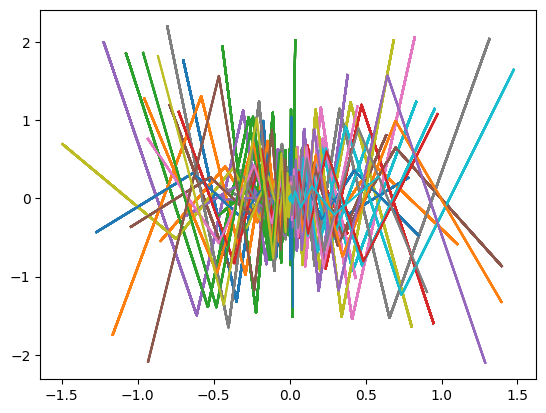

In [33]:
np.random.seed(420) # set the seed for reproducibility 
num_trials = 50 # number of resets
tf = 3
horizon = int(tf/model.dt) # how long we simulate the system for
M = num_trials * horizon # M sized data

traj = np.zeros([2, horizon, num_trials])

### Choose basis functions ###
obs_choice = 2  # if handmade basis is used
order = 5  # if (hermitian) polynomials are used
cross_terms = False

obs = Observables(obs_choice, order, cross_terms)
z = obs.hermite # choose which basis functions you want to use

num_obs = len(z(model.reset()))
print("size of dictionary: ", num_obs)

# EDMD matrices
A = np.zeros((num_obs, num_obs))
G = np.zeros((num_obs, num_obs))
L = np.zeros((num_obs, num_obs))

for k in range(num_trials):
    xt = model.reset()
    for t in range(horizon):
        xt_new = model.step()
        traj[:, t, k] = xt_new
 
        A += np.outer(z(xt_new), z(xt))
        G += np.outer(z(xt), z(xt))
        L += np.outer(z(xt_new), z(xt_new))

    plt.plot(traj[0], traj[1]) # plot trajectories used for
A /= M
G /= M
L /= M

koopman = np.dot(A, np.linalg.pinv(G))
cont_koopman = logm(koopman)/model.dt

## Compute the residual, as defined in Matthew Colbrook's ResDMD

In [34]:
evals, evecs = np.linalg.eig(koopman)
residuals = np.zeros(len(evals))

for i in range(len(evals)):
    evec_mat = np.asmatrix(evecs[:,i]).T
    lam = evals[i]
    numer = evec_mat.H@(L - lam*A.T - np.conj(lam)*A + np.absolute(lam)**2*G)@evec_mat
    denom = evec_mat.H@G@evec_mat
    residuals[i] = np.sqrt(np.real(numer[0,0])/np.real(denom[0,0]))

## Analysis of results

|eval|:  0.9999999999999964 .......... res:  1.2315147872900574
|eval|:  0.00428571428571496 .......... res:  0.45813000254770575
|eval|:  0.0015428571428342565 .......... res:  0.41452161906275503
|eval|:  6.28981683207425e-17 .......... res:  0.6820126512519792
|eval|:  0.0011111111111155986 .......... res:  0.41473152731927493
|eval|:  0.00022222222223140247 .......... res:  0.38222693570822
|eval|:  0.0033333333333329675 .......... res:  0.028766101098737982
|eval|:  0.001428571428570849 .......... res:  0.041176955177175754
|eval|:  0.0009890109890110929 .......... res:  0.034088760758470796
|eval|:  0.0004761904761904294 .......... res:  0.02320528931248432
Is residual faithful?  True
Is residual faithful?  False
Is residual faithful?  False
Is residual faithful?  True
Is residual faithful?  False
Is residual faithful?  False
Is residual faithful?  False
Is residual faithful?  False
Is residual faithful?  False
Is residual faithful?  False


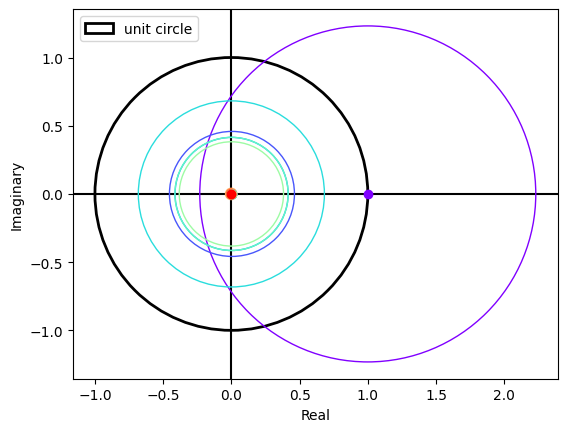

In [36]:
# Print out the learned eigenvalues and their associated error
for i, eval in enumerate(evals):
    print("|eval|: ", np.absolute(eval), ".......... res: ", residuals[i])

# If the model is a linear system, compare ResDMD error with the known error
if model.name == "LinearSystem":
    for i, eval in enumerate(evals):
        a = np.abs(eval - model.evals[0])
        b = np.abs(eval - model.evals[1])
        print("Is residual faithful? ", min([a,b]) < residuals[i])

# Plot learned eigenvalues with the ResDMD error
fig, ax = plt.subplots()
plt.xlabel('Real')
plt.ylabel('Imaginary')

ax.set_aspect('equal', adjustable='box')
ax.axhline(y=0, color='k', zorder=0)
ax.axvline(x=0, color='k', zorder=0)
unit_circle = plt.Circle((0., 0.), 1, color='k', linewidth=2, fill=False, label='unit circle')
ax.add_patch(unit_circle)

color = plt.cm.rainbow(np.linspace(0, 1, len(evals)))
for i in range(len(evals)):
    circle = plt.Circle((evals[i].real, evals[i].imag), residuals[i], color=color[i], fill=False)
    ax.add_patch(circle)

# separate for loop so eigenvalues show up on top of everything
for i in range(len(evals)):
    plt.scatter(evals[i].real, evals[i].imag, color=color[i])

plt.legend()

#### In the above plot, 
* Points represent the learned eigenvalues
* Circles with the same color correspond to the ResDMD error
* Black circle is the unit circle